<a href="https://colab.research.google.com/github/povembu/NLP-project-D590/blob/main/NLP_Project_Part2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Part 2
# Text Classification of Online Hate Speech

## By Binh Bui, Pooja Rajan, and Alexander Watkins


The purpose of this notebook is to create a model capable of classifying text as either hate speech or non hate speech. This process is broken down into 3 major steps:

*   Preprocessing (dataset prep, train/test split, and text cleaning and normalization)
*   Feature extraction (vectorization)
*   Model creation (model creation, model evaluation, and classification tests)

The preprocessing and feature extraction steps involved the standard procedures to prepare a dataset for NLP. For model creation we tested a variety of different models and feature extraction methods to determine which process best suited our data. The chosen model was then applied to sample texts to demonstrate its effectiveness.

## Dataset Prep

### Dataset Loading

In [ ]:
!pip install datasets #install datasets library for HuggingFace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import spacy
import unicodedata
import re
from nltk.corpus import wordnet
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
dataset = load_dataset('hate_speech18')

Generating train split:   0%|          | 0/10944 [00:00<?, ? examples/s]

### Dataset Reformatting

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})


In [ ]:
dataset.set_format(type='pandas',columns=['text', 'user_id', 'subforum_id', 'num_contexts', 'label'])

In [ ]:
hate_df = dataset['train'][:]
hate_df.shape

(10944, 5)

In [ ]:
hate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          10944 non-null  object
 1   user_id       10944 non-null  int64 
 2   subforum_id   10944 non-null  int64 
 3   num_contexts  10944 non-null  int64 
 4   label         10944 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 427.6+ KB


### Dataset Filtering

These are the label values in the dataset and there corresponding meaning:


In [ ]:
hate_df['label'].unique()

''' 0 - no hate
    1 - hate speech
    2 - idk/skip
    3 - relation '''

' 0 - no hate\n    1 - hate speech\n    2 - idk/skip\n    3 - relation '

In [ ]:
pd.options.display.max_colwidth = 200
hate_df.loc[hate_df['label'] == 2].head()

,text,user_id,subforum_id,num_contexts,label
254,Glædelig jul !,573835,1393,0,2
267,"Det er forresten en ting til Órkneyjar vil si deg , `` Tack så mycket . ''",572043,1393,0,2
292,Jag har inte själv varit med någon gång men jag har stor respekt för de som deltar .,589670,1393,1,2
296,Suomalainen totta kai !,581207,1393,0,2
471,ApÃ © ro gÃ © ant : trois jeunes soupÃ § onnÃ © s de viol https : //www.stormfront.org/forum/t809905/,579750,1383,0,2


2 and 3 target label don't make much sense.
'idk/skip' - 2 is used wherever they are not sure of the sentiment of a comment. It could be a different language/some URLs
'relation' - 3 seems like a constructive feedback/a normal comment on something.

In [ ]:
hate_df['label'].value_counts()

0    9507
1    1196
3     168
2      73
Name: label, dtype: int64

Given the focus of this project on the differentiation between hate speech/no hate speech and the limited number of occurences for labels 2 and 3, rows with labels 2 and 3 are removed.

In [ ]:
hate_df = hate_df[hate_df['label']!=2]
hate_df = hate_df[hate_df['label']!=3]

In [ ]:
hate_df['label'].value_counts()

0    9507
1    1196
Name: label, dtype: int64

In [ ]:
hate_df = hate_df[['text','label']]
hate_df.head()

,text,label
0,"As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .",0
1,"In order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded You...",0
2,( Simply copy and paste the following text into your YouTube videos description boxes. ),0
3,Click below for a FREE download of a colorfully illustrated 132 page e-book on the Zionist-engineered INTENTIONAL destruction of Western civilization .,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green banner link .,0


### Dataset Exploration

There are no null values in either column:

In [ ]:
total_nulls = hate_df[hate_df.text.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)

Empty documents: 0


<Axes: >

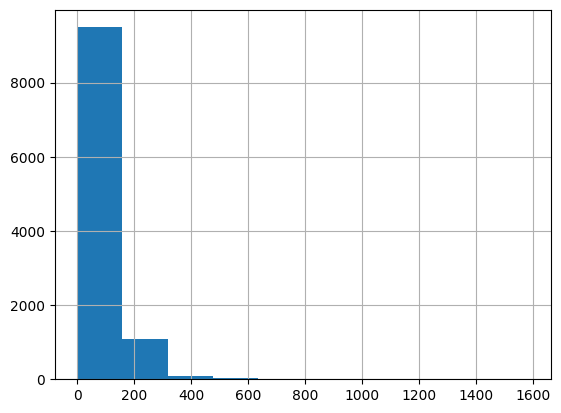

In [ ]:
hate_df['text'].str.len().hist() #number of characters present in each sentence

<Axes: >

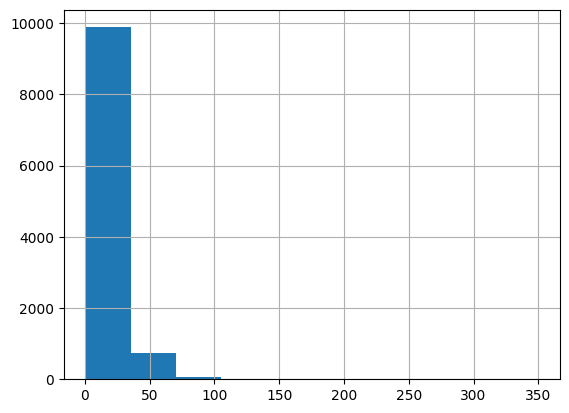

In [ ]:
hate_df['text'].str.split().map(lambda x: len(x)).hist() #number of words - has a range of 0-40

<Axes: >

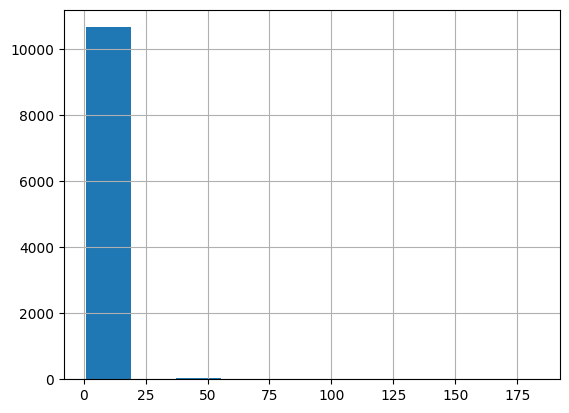

In [ ]:
hate_df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist() #avg word length - between 1 - 20

## Train/test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hate_df['text'], hate_df['label'], test_size=0.2, random_state=42, stratify=hate_df['label'])

In [ ]:
train_X = np.array(X_train)
test_X = np.array(X_test)
train_y = np.array(y_train)
test_y = np.array(y_test)

## Text cleaning and normalization

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')

In [ ]:
nlp = spacy.load('en_core_web_sm')
tokenizer = ToktokTokenizer()

In [ ]:
def simple_porter_stemming(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, is_lower_case=False, stopwords=stop_words):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_text(corpus, text_lower_case=True,
                     text_stemming=False, text_lemmatization=True,
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True,stopwords=stop_words):

    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:

        # remove extra newlines
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))

        # lemmatize text
        if text_lemmatization:
          doc = lemmatize_text(doc)

        # stem text
        if text_stemming and not text_lemmatization:
          doc = simple_porter_stemming(doc)

        # remove special characters and\or digits
        if special_char_removal:
          # insert spaces between special characters to isolate them
          special_char_pattern = re.compile(r'([{.(-)!}])')
          doc = special_char_pattern.sub(" \\1 ", doc)
          doc = remove_special_characters(doc, remove_digits=remove_digits)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)

         # lowercase the text
        if text_lower_case:
          doc = doc.lower()

        # remove stopwords
        if stopword_removal:
          doc = remove_stopwords(doc, is_lower_case=text_lower_case, stopwords=stopwords)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()

        normalized_corpus.append(doc)

    return normalized_corpus

In [ ]:
norm_train_X = normalize_text(train_X, stopwords=stop_words)
norm_test_X = normalize_text(test_X, stopwords=stop_words)

In [ ]:
norm_train_X[:5]

['rampage productions welcome blood honour forum',
 'refer primate evolution process little bit high evolutionary chain make dangerous white animalistic cousin',
 'hungarian academy sciences semmelweis university institute forensic medicine budapest hungary e mail bujgyoigaz sote hu hey look even year csabi hungarian music popularity romania except case exact source specify documentation contact material not sensationalist newspaper but hungarian universities',
 'worried not well',
 'noble idea but would rather stay mostly white missouri move black south carolina']

## Vectorization

### Word2Vec
Best suit for semantic analysis. It is great for capturing context of words.

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus.[3]

In [ ]:
df_norm_train_X = pd.DataFrame(norm_train_X, columns=['X'])
df_norm_train_X.head()

,X
0,rampage productions welcome blood honour forum
1,refer primate evolution process little bit high evolutionary chain make dangerous white animalistic cousin
2,hungarian academy sciences semmelweis university institute forensic medicine budapest hungary e mail bujgyoigaz sote hu hey look even year csabi hungarian music popularity romania except case exac...
3,worried not well
4,noble idea but would rather stay mostly white missouri move black south carolina


In [ ]:
df_norm_test_X = pd.DataFrame(norm_test_X, columns=['X'])
df_norm_test_X.head()

,X
0,sound like heavenly community
1,year go dog two friend go ghost mail man
2,not
3,
4,see opp know name stand congrat nice looking boyfriend read opp awhile see take pic yet put


In [ ]:
import gensim
from gensim.models import Word2Vec

norm_train_X_token = df_norm_train_X.X.apply(gensim.utils.simple_preprocess)
norm_train_X_token.head()

0                                                                                                                                                      [rampage, productions, welcome, blood, honour, forum]
1                                                                                  [refer, primate, evolution, process, little, bit, high, evolutionary, chain, make, dangerous, white, animalistic, cousin]
2    [hungarian, academy, sciences, semmelweis, university, institute, forensic, medicine, budapest, hungary, mail, bujgyoigaz, sote, hu, hey, look, even, year, csabi, hungarian, music, popularity, rom...
3                                                                                                                                                                                       [worried, not, well]
4                                                                                                             [noble, idea, but, would, rather, stay, mostly, white, missouri, move,

In [ ]:
norm_test_X_token = df_norm_test_X.X.apply(gensim.utils.simple_preprocess)
norm_test_X_token.head()

0                                                                               [sound, like, heavenly, community]
1                                                               [year, go, dog, two, friend, go, ghost, mail, man]
2                                                                                                            [not]
3                                                                                                               []
4    [see, opp, know, name, stand, congrat, nice, looking, boyfriend, read, opp, awhile, see, take, pic, yet, put]
Name: X, dtype: object

In [ ]:
model=Word2Vec(norm_train_X_token,window=5, min_count=2, workers=4, sg=0)

model.build_vocab(norm_train_X_token, progress_per=1000)
model.train(norm_train_X_token, total_examples=model.corpus_count, epochs=model.epochs)

model.save("./speech.model")

In [ ]:
def get_text2vec(words):
  vectors = [model.wv[word] for word in words if word in model.wv]
  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(model.vector_size)

In [ ]:
text2vec_train_X = norm_train_X_token.apply(get_text2vec)
text2vec_train_X.head()

0    [-0.48775142, 0.6396986, 0.14451051, 0.1167997, 0.013007507, -1.1527827, 0.2438913, 1.4444444, -0.78290343, -0.38593635, -0.27375004, -1.106189, 0.082522765, 0.24266881, 0.23394598, -0.3943703, 0....
1    [-0.46496695, 0.58949316, 0.12547493, 0.10579297, 0.013193502, -1.1037709, 0.2083459, 1.3838875, -0.7574176, -0.34780473, -0.27059358, -1.0451251, 0.067125574, 0.23532969, 0.21623573, -0.36311784,...
2    [-0.42584985, 0.5420371, 0.114479564, 0.095968015, 0.009440796, -1.016321, 0.19437012, 1.2726414, -0.69343346, -0.32181507, -0.24864802, -0.96153265, 0.07149881, 0.21983486, 0.19960132, -0.3391650...
3    [-0.4132925, 0.51534754, 0.09437259, 0.08421069, 0.022393892, -0.9691539, 0.18175776, 1.2188643, -0.67192954, -0.2927345, -0.23833513, -0.9129006, 0.058776546, 0.20067048, 0.18613923, -0.31653225,...
4    [-0.39733645, 0.504473, 0.1037347, 0.09399637, 0.008614858, -0.9503581, 0.17836922, 1.1920578, -0.65476394, -0.29732198, -0.23729481, -0.8907795, 0.05811841, 0.20396689, 0.186

In [ ]:
text2vec_test_X = norm_test_X_token.apply(get_text2vec)
text2vec_test_X.head()

0    [-0.31405357, 0.39183918, 0.07683793, 0.064100325, 0.017815081, -0.74382734, 0.1325689, 0.92545366, -0.51276094, -0.23559053, -0.1798477, -0.6914106, 0.04096299, 0.15535639, 0.1495097, -0.24096864...
1    [-0.35207304, 0.44533914, 0.09824843, 0.07904472, 0.0067117345, -0.8479407, 0.15197743, 1.0505259, -0.57292277, -0.2677572, -0.20505728, -0.7973081, 0.059302792, 0.18111694, 0.17124811, -0.2812855...
2    [-0.3964781, 0.4953035, 0.077224754, 0.07639645, 0.027609717, -0.95989376, 0.18022387, 1.1988236, -0.65342474, -0.2829197, -0.21762162, -0.8779726, 0.04010674, 0.19459428, 0.17721741, -0.30059576,...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [-0.30123737, 0.38457, 0.07804428, 0.06606511, 0.008812682, -0.7155181, 0.13110875, 0.8971039, -0.4861974, -0.21923031, -0.17853393, -0.6719507, 0.04214304, 0.15359637, 0.1464

### CountVectorizer and TfidVectorizer


Count Vectorizer is a way to convert a given set of strings into a frequency representation. Count Vectorizers can be helpful in understanding the type of text by the frequency of words in it. [2]


---------------------

TFIDF is based on the logic that words that are too abundant in a corpus and words that are too rare are both not statistically important for finding a pattern. The Logarithmic factor in tfidf mathematically penalizes the words that are too abundant or too rare in the corpus by giving them low tfidf scores.
Higher value of tfidf signifies higher importance of the words in the corpus while lower values represent lower importance.[2]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train text
cv = CountVectorizer(ngram_range=(1,2),stop_words=stop_words).fit(norm_train_X)
cv_train_features = cv.transform(norm_train_X)
# build TFIDF features on train text
tv = TfidfVectorizer(ngram_range=(1,2),stop_words=stop_words).fit(norm_train_X)
tv_train_features = tv.transform(norm_train_X)

In [ ]:
# transform test reviews into features
cv_test_features = cv.transform(norm_test_X)
tv_test_features = tv.transform(norm_test_X)

In [ ]:
cv_train_X = pd.DataFrame(cv_train_features.toarray(), columns=cv.get_feature_names_out())
cv_test_X = pd.DataFrame(cv_test_features.toarray(), columns=cv.get_feature_names_out())
tv_train_X = pd.DataFrame(tv_train_features.toarray(), columns=tv.get_feature_names_out())
tv_test_X = pd.DataFrame(tv_test_features.toarray(), columns=tv.get_feature_names_out())

## Model Creation
- X:
  * Word2Vec: text2vec_train_X, text2vec_test_X
  * CountVectorizer: cv_train_X, cv_test_X
  * TfidVectorizer: tv_train_X, tv_test_X
- y: train_y, test_y

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

During the model creation process various strategies were employed to determine which format worked best for our dataset. In some cases a grid search was used to determine the best hyperparameters for certain model types. This process takes a significant amount of time to run, so the code is commented out. Instead, the parameters determined by the search are manually assigned after the commented code.

### MultinomialNB Model

#### Using CountVectorizer

In [ ]:
#mnb_cv = MultinomialNB(alpha=1)

In [ ]:
#mnb_parameters = {
#    'alpha': (1e-1,1e-3,1e-5,1e-7,1e-9,1e-10)
#}

In [ ]:
#gs_mnbcv = GridSearchCV(mnb_cv, mnb_parameters, cv=5)

In [ ]:
#gs_mnbcv = gs_mnbcv.fit(cv_train_X, train_y)

In [ ]:
#gs_mnbcv.best_score_

In [ ]:
#gs_mnbcv.best_params_

In [ ]:
#param_a = gs_mnbcv.best_params_['alpha']

In [ ]:
param_a = 1e-10

Creates model using best value for alpha

In [ ]:
mnb_cv = MultinomialNB(alpha=param_a)
mnb_cv.fit(cv_train_X, y_train)

MultinomialNB(alpha=1e-10)

Predicts labels on train/test data

In [ ]:
mnb_cv_test_predict = mnb_cv.predict(cv_test_X)
mnb_cv_train_predict = mnb_cv.predict(cv_train_X)
np.mean(mnb_cv_test_predict == y_test) # % correct predictions on test data

0.8664175618869687

Calculate model evaluation stats

In [ ]:
mnb_cv_test_report = metrics.classification_report(y_test,mnb_cv_test_predict,labels=[0,1])
mnb_cv_train_report = metrics.classification_report(y_train,mnb_cv_train_predict,labels=[0,1])

In [ ]:
print(mnb_cv_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7605
           1       0.99      1.00      0.99       957

    accuracy                           1.00      8562
   macro avg       0.99      1.00      1.00      8562
weighted avg       1.00      1.00      1.00      8562



In [ ]:
print(mnb_cv_test_report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1902
           1       0.35      0.24      0.29       239

    accuracy                           0.87      2141
   macro avg       0.63      0.59      0.61      2141
weighted avg       0.85      0.87      0.85      2141



#### Using Tfidf

In [ ]:
mnb_tf = MultinomialNB(alpha = param_a)
mnb_tf.fit(tv_train_X, y_train)

MultinomialNB(alpha=1e-10)

In [ ]:
mnb_tf_test_predict = mnb_tf.predict(tv_test_X)
mnb_tf_train_predict = mnb_tf.predict(tv_train_X)
np.mean(mnb_tf_test_predict == y_test)

0.8762260625875758

In [ ]:
mnb_tv_test_report = metrics.classification_report(y_test,mnb_tf_test_predict,labels=[0,1])
mnb_tv_train_report = metrics.classification_report(y_train,mnb_tf_train_predict,labels=[0,1])

In [ ]:
print(mnb_tv_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7605
           1       1.00      1.00      1.00       957

    accuracy                           1.00      8562
   macro avg       1.00      1.00      1.00      8562
weighted avg       1.00      1.00      1.00      8562



In [ ]:
print(mnb_tv_test_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1902
           1       0.38      0.16      0.23       239

    accuracy                           0.88      2141
   macro avg       0.64      0.56      0.58      2141
weighted avg       0.84      0.88      0.85      2141



### SGDC Model

#### Using CountVectorizer

In [ ]:
#sgdc_cv = SGDClassifier(max_iter = 10000,
#                         tol = 1e-3,
#                         penalty = 'l2',
#                         loss = 'log_loss',
#                         alpha = 0.0000001,
#                         random_state = 117)

In [ ]:
#sgdc_parameters = {
#    'alpha': (1e-1,1e-3,1e-5,1e-7,1e-9),
#    'tol': (1e-1,1e-3,1e-5,1e-7,1e-9),
#    'max_iter': (50,100,500,1000)
#}

In [ ]:
#gs_sgdc = GridSearchCV(sgdc_cv, sgdc_parameters, cv=5)
#gs_sgdc = gs_sgdc.fit(cv_train_X, train_y)

In [ ]:
#gs_sgdc.best_score_

In [ ]:
#gs_sgdc.best_params_

In [ ]:
#param_a = gs_sgdc.best_params_['alpha']
#param_tol = gs_sgdc.best_params_['tol']
#param_iter = gs_sgdc.best_params_['max_iter']

The grid search takes a while, so manually setting the parameters for subsequent runs

In [ ]:
param_a = 1e-9
param_tol = 1e-9
param_iter = 10000

In [ ]:
sgdc_cv = SGDClassifier(max_iter = param_iter,
                         tol = param_tol,
                         penalty = 'l2',
                         loss = 'log_loss',
                         alpha = param_a,
                         random_state = 117)

In [ ]:
sgdc_cv.fit(cv_train_X, y_train)

SGDClassifier(alpha=1e-09, loss='log_loss', max_iter=10000, random_state=117,
              tol=1e-09)

In [ ]:
sgdc_cv_test_predict = sgdc_cv.predict(cv_test_X)
sgdc_cv_train_predict = sgdc_cv.predict(cv_train_X)

In [ ]:
sgdc_cv_test_report = metrics.classification_report(y_test,sgdc_cv_test_predict,labels=[0,1])
sgdc_cv_train_report = metrics.classification_report(y_train,sgdc_cv_train_predict,labels=[0,1])

In [ ]:
print(sgdc_cv_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7605
           1       0.98      1.00      0.99       957

    accuracy                           1.00      8562
   macro avg       0.99      1.00      0.99      8562
weighted avg       1.00      1.00      1.00      8562



In [ ]:
print(sgdc_cv_test_report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1902
           1       0.53      0.34      0.41       239

    accuracy                           0.89      2141
   macro avg       0.72      0.65      0.68      2141
weighted avg       0.88      0.89      0.88      2141



#### Using Tfidf

In [ ]:
#sgdc_tv = SGDClassifier(max_iter = 10000,
#                         tol = 1e-3,
#                         penalty = 'l2',
#                         loss = 'log_loss',
#                         alpha = 0.0000001,
#                         random_state = 117)

In [ ]:
#sgdc_parameters = {
#    'alpha': (1e-1,1e-10)
#}

In [ ]:
#gs_sgdc = GridSearchCV(sgdc_tv, sgdc_parameters, cv=5)
#gs_sgdc = gs_sgdc.fit(tv_train_X, train_y)

In [ ]:
#gs_sgdc.best_score_

In [ ]:
#gs_sgdc.best_params_

In [ ]:
#param_a = gs_sgdc.best_params_['alpha']

In [ ]:
sgdc_tv = SGDClassifier(max_iter = param_iter,
                         tol = param_tol,
                         penalty = 'l2',
                         loss = 'log_loss',
                         alpha = param_a,
                         random_state = 117)

In [ ]:
sgdc_tv.fit(tv_train_X, y_train)

SGDClassifier(alpha=1e-09, loss='log_loss', max_iter=10000, random_state=117,
              tol=1e-09)

In [ ]:
sgdc_tv_test_predict = sgdc_tv.predict(tv_test_X)
sgdc_tv_train_predict = sgdc_tv.predict(tv_train_X)

In [ ]:
sgdc_tv_test_report = metrics.classification_report(y_test,sgdc_tv_test_predict,labels=[0,1])
sgdc_tv_train_report = metrics.classification_report(y_train,sgdc_tv_train_predict,labels=[0,1])

In [ ]:
print(sgdc_tv_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7605
           1       0.99      1.00      1.00       957

    accuracy                           1.00      8562
   macro avg       1.00      1.00      1.00      8562
weighted avg       1.00      1.00      1.00      8562



In [ ]:
print(sgdc_tv_test_report)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1902
           1       0.41      0.43      0.42       239

    accuracy                           0.87      2141
   macro avg       0.67      0.68      0.67      2141
weighted avg       0.87      0.87      0.87      2141



### SVC

In [ ]:
#svc = LinearSVC(fit_intercept=True,
#                random_state = 117,
#                max_iter = 10000,
#                penalty = 'l2')

Uses grid search to tune hyperparameter value(s)

In [ ]:
#svc_parameters = {
#    'tol': (1e-1,1e-8),
#    'C': [0.5,1,1.5,5],
#    'intercept_scaling': [1, 5, 10]
#}

In [ ]:
#gs_svc = GridSearchCV(svc, svc_parameters, cv=5)

In [ ]:
#gs_svc = gs_svc.fit(cv_train_X, train_y)

In [ ]:
#gs_svc.best_score_

In [ ]:
#gs_svc.best_params_

In [ ]:
#param_tol = gs_svc.best_params_['tol']
#param_c = gs_svc.best_params_['C']
#param_int = gs_svc.best_params_['intercept_scaling']

In [ ]:
param_tol = 1e-8
param_c = 1
param_int = 1

In [ ]:
svc = LinearSVC(fit_intercept=True,
                random_state = 117,
                max_iter = 10000,
                penalty = 'l2',
                C = param_c,
                tol = param_tol,
                intercept_scaling = param_int)

Creates model using best value for alpha

In [ ]:
svc.fit(cv_train_X, y_train)

LinearSVC(C=1, max_iter=10000, random_state=117, tol=1e-08)

Predicts labels on train/test data

In [ ]:
svc_test_predict = svc.predict(cv_test_X)
svc_train_predict = svc.predict(cv_train_X)
np.mean(svc_test_predict == y_test) # % correct predictions on test data

0.9047174217655302

In [ ]:
svc_test_report = metrics.classification_report(y_test,svc_test_predict,labels=[0,1])
svc_train_report = metrics.classification_report(y_train,svc_train_predict,labels=[0,1])

In [ ]:
print(svc_train_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7605
           1       1.00      1.00      1.00       957

    accuracy                           1.00      8562
   macro avg       1.00      1.00      1.00      8562
weighted avg       1.00      1.00      1.00      8562



In [ ]:
print(svc_test_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1902
           1       0.68      0.28      0.39       239

    accuracy                           0.90      2141
   macro avg       0.80      0.63      0.67      2141
weighted avg       0.89      0.90      0.89      2141



### Logistic Regression (Intial tests)

#### Count Vectorizer

In [ ]:
#lr = LogisticRegression()
#lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=117)

In [ ]:
#lr_parameters = {
#    'penalty': ('l1','l2','elasticnet'),
#    'tol': (1e-1,1e-3,1e-5,1e-7),
#    #'C': (0.5,1,5,10),
#    #'max_iter': (50,100, 500, 1000)
#}

In [ ]:
#gs_lr = GridSearchCV(lr, lr_parameters, cv=5)
#gs_lr = gs_lr.fit(cv_train_X, train_y)

In [ ]:
#gs_lr.best_score_

In [ ]:
#gs_lr.best_params_

In [ ]:
#param_pen = gs_sgdc.best_params_['penalty']
#param_tol = gs_sgdc.best_params_['tol']
#param_c = gs_sgdc.best_params_['C']
#param_iter = gs_sgdc.best_params_['max_iter']

In [ ]:
param_pen = 'l1'
param_tol = 1e-10
param_c = 1
param_iter = 10000

In [ ]:
lr = LogisticRegression(max_iter = param_iter,
                        tol = param_tol,
                         penalty = param_pen,
                         C = param_c,
                         solver = 'liblinear',
                         random_state = 117)

In [ ]:
lr.fit(cv_train_X, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=1, max_iter=10000, penalty='l1', random_state=117,
                   solver='liblinear', tol=1e-10)

In [ ]:
lr_test_predict = lr.predict(cv_test_X)

In [ ]:
lr_test_report = metrics.classification_report(y_test,lr_test_predict,labels=[0,1])

In [ ]:
print(lr_test_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1902
           1       0.65      0.30      0.41       239

    accuracy                           0.90      2141
   macro avg       0.78      0.64      0.68      2141
weighted avg       0.89      0.90      0.89      2141



#### Tfidf

In [ ]:
lr_tf = LogisticRegression(max_iter = 10000,
                         tol = 1e-10,
                         penalty = 'l2',
                         C = 1,
                         random_state = 117)

In [ ]:
lr_tf.fit(tv_train_X, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=117, tol=1e-10)

In [ ]:
lr_tf_test_predict = lr_tf.predict(tv_test_X)

In [ ]:
lr_tf_test_report = metrics.classification_report(y_test,lr_tf_test_predict,labels=[0,1])

In [ ]:
print(lr_tf_test_report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1902
           1       0.43      0.01      0.02       239

    accuracy                           0.89      2141
   macro avg       0.66      0.51      0.48      2141
weighted avg       0.84      0.89      0.84      2141



### Logistic Regression (Further Investigation)

After seeing favorable results with the logistic regression model, we spent more time investigating this model type specifically.

#### Logistic Regression using CountVectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

#fit the model
lr_cv = LogisticRegression(
                         class_weight ='balanced',random_state=42)
lr_cv.fit(cv_train_X, train_y)

#predict using the trained model
y_pred_cv_lr = lr_cv.predict(cv_test_X)

#evaluation metrics
lr_cv_acc = accuracy_score(test_y,y_pred_cv_lr)
lr_cv_f1 = f1_score(test_y, y_pred_cv_lr)
lr_cv_recall = recall_score(test_y, y_pred_cv_lr)
lr_cv_precision =  precision_score(test_y, y_pred_cv_lr)
tn_cv, fp_cv, fn_cv, tp_cv = confusion_matrix(test_y, y_pred_cv_lr).ravel()

In [ ]:
lr_cv_report = (metrics.classification_report(y_test,y_pred_cv_lr,labels=[0,1]))

#### Logistic Regression using Tf-Idf vectorizer

In [ ]:
#fit the model
lr_tv = LogisticRegression(
                           class_weight ='balanced',
                           random_state=42)
lr_tv.fit(tv_train_X, train_y)

#predict using trained model
y_pred_tv_lr = lr_tv.predict(tv_test_X)

#evaluation metrics
lr_tv_acc = accuracy_score(test_y,y_pred_tv_lr)
lr_tv_f1 = f1_score(test_y, y_pred_tv_lr)
lr_tv_recall = recall_score(test_y, y_pred_tv_lr)
lr_tv_precision =  precision_score(test_y, y_pred_tv_lr)
tn_tv, fp_tv, fn_tv, tp_tv = confusion_matrix(test_y, y_pred_tv_lr).ravel()

In [ ]:
lr_tv_report = (metrics.classification_report(y_test,y_pred_tv_lr,labels=[0,1]))

#### Logistic Regression using Word2Vec

In [ ]:
text2vec_train_X = np.array([get_text2vec(word) for word in norm_train_X_token])
text2vec_test_X = np.array([get_text2vec(word) for word in norm_test_X_token])

In [ ]:
#fit the model
lr_t2v = LogisticRegression(
                            class_weight ='balanced',
                            random_state=42)
lr_t2v.fit(text2vec_train_X, train_y)

#predict using the trained model
y_pred_t2v_lr = lr_t2v.predict(text2vec_test_X)

#evaluation metrics
lr_t2v_acc = accuracy_score(test_y,y_pred_t2v_lr)
lr_t2v_f1 = f1_score(test_y, y_pred_t2v_lr)
lr_t2v_recall = recall_score(test_y, y_pred_t2v_lr)
lr_t2v_precision =  precision_score(test_y, y_pred_t2v_lr)
tn_t2v, fp_t2v, fn_t2v, tp_t2v = confusion_matrix(test_y, y_pred_t2v_lr).ravel()

In [ ]:
lr_t2v_report = (metrics.classification_report(y_test,y_pred_t2v_lr,labels=[0,1]))

#### Logistic Regression CV/TFIDF/W2V Comparison

In [ ]:
pd.DataFrame([
              ['Logistic Regression - CountVectorizer',  np.round(lr_cv_acc,4),
               np.round(lr_cv_f1,4), np.round(lr_cv_recall,4),np.round(lr_cv_precision,4),tn_cv,fp_cv,fn_cv,tp_cv],
              ['Logistic Regression - Tf-Idf Vectorizer', np.round(lr_tv_acc,4),
               np.round(lr_tv_f1,4), np.round(lr_tv_recall,4),np.round(lr_tv_precision,4),tn_tv,fp_tv,fn_tv,tp_tv],
              ['Logistic Regression - Word2Vec',  np.round(lr_t2v_acc,4),
               np.round(lr_t2v_f1,4), np.round(lr_t2v_recall,4),np.round(lr_t2v_precision,4),tn_t2v,fp_t2v,fn_t2v,tp_t2v],
              ],
             columns=['Model', 'Accuracy Score', 'F1 score', 'Recall','Precision', 'TN','FP','FN','TP'],
             ).T

,0,1,2
Model,Logistic Regression - CountVectorizer,Logistic Regression - Tf-Idf Vectorizer,Logistic Regression - Word2Vec
Accuracy Score,0.8986,0.8557,0.5955
F1 score,0.4668,0.4841,0.2534
Recall,0.3975,0.6067,0.6151
Precision,0.5655,0.4028,0.1596
TN,1829,1687,1128
FP,73,215,774
FN,144,94,92
TP,95,145,147


Logistic Regression performs better with Count Vectorizer as the vectorization method among the three and has better accuracy and a very decent F1 score. In terms of true predictions, this model is capable of learning and predicting the true labels on the unseen dataset.

### LSTM

### GloVe Word Embedding

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2023-11-19 13:14:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.97MB/s    in 2m 40s  

2023-11-19 13:17:20 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
words = dict()

def add_to_dict(d, filename):
  with open(filename,'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words,'glove.6B.50d.txt')

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def mes_token_list(s):
  tokens = tokenizer.tokenize(s)
  low_tokens = [t.lower() for t in tokens]
  lem_tokens = [lem.lemmatize(x) for x in low_tokens]
  tks = [x for x in lem_tokens if x in words]
  return tks

def mes_word_vector(mes, word_dict=words):
  lt_of_tks = mes_token_list(mes)
  vts = []
  for t in lt_of_tks:
    if t not in word_dict:
      continue

    vts.append(word_dict[t])
  return np.array(vts, dtype=float)

In [ ]:
mes_word_vector('No wonder young people ca n\'t get jobs .').shape

(11, 50)

In [ ]:
def to_X(np_arr):
  seqs = []
  for mes in np_arr:
    mes_vt = mes_word_vector(mes)
    if mes_vt.shape[0]==0:
      mes_vt = np.zeros(shape=(1,50))
    seqs.append(mes_vt)
  return seqs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hate_df['text'], hate_df['label'], test_size=0.1, random_state=42,shuffle=True, stratify=hate_df['label'])

print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_test).value_counts())

label
0        8556
1        1076
dtype: int64
label
0        951
1        120
dtype: int64


In [ ]:
X_train = to_X(X_train)
X_test = to_X(X_test)

In [ ]:
print("length of X train: ", len(X_train))

length of X train:  9632


(array([8.801e+03, 7.520e+02, 5.500e+01, 1.800e+01, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  34.9,  68.8, 102.7, 136.6, 170.5, 204.4, 238.3, 272.2,
        306.1, 340. ]),
 <BarContainer object of 10 artists>)

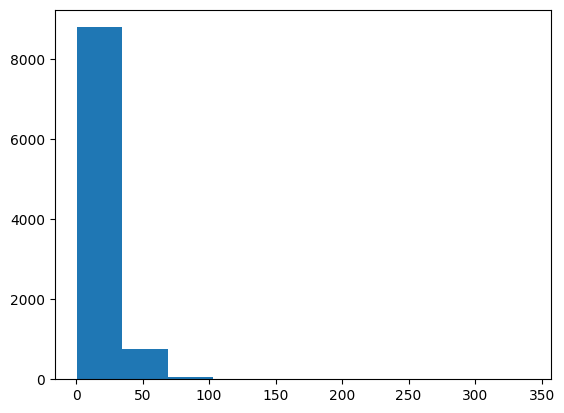

In [ ]:
seq_lens = []
for i in range(len(X_train)):
  seq_lens.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(seq_lens)

In [ ]:
pd.Series(seq_lens).describe()

count    9632.000000
mean       18.302533
std        13.925482
min         1.000000
25%         9.000000
50%        16.000000
75%        25.000000
max       340.000000
dtype: float64

In [ ]:
from copy import deepcopy

def pad0(X, seq_len=340):
  X_copy = deepcopy(X)

  for i,x in enumerate(X):
    x_seq_len = x.shape[0]
    seq_len_diff = seq_len - x_seq_len

    pad = np.zeros(shape=(seq_len_diff,50))
    X_copy[i] = np.concatenate([x,pad])

  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad0(X_train)
X_test = pad0(X_test)
print(X_train.shape)
print(X_test.shape)

(9632, 340, 50)
(1071, 340, 50)


### LSTM model training

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])
model.add(layers.Input(shape=(340,50)))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(128,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 340, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 340, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 340, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 340, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 340, 64)           49408     
                                                                 
 dropout_2 (Dropout)         (None, 340, 64)           0         
                                                                 
 flatten (Flatten)           (None, 21760)             0

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),loss=BinaryCrossentropy(),
              metrics=['accuracy',AUC(name='auc')])

In [ ]:
freq = pd.DataFrame(y_train).value_counts()
weights = {0: freq.sum()/freq[0], 1: freq.sum()/freq[1]}
print(freq)
print(weights)

label
0        8556
1        1076
dtype: int64
{0: 1.125759700794764, 1: 8.951672862453531}


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=15,callbacks=[cp],class_weight=weights)

Epoch 1/15
301/301 [==============================] - 434s 1s/step - loss: 1.2536 - accuracy: 0.5972 - auc: 0.7102 - val_loss: 0.5273 - val_accuracy: 0.7582 - val_auc: 0.8061
Epoch 2/15
301/301 [==============================] - 429s 1s/step - loss: 1.0708 - accuracy: 0.7249 - auc: 0.8071 - val_loss: 0.3346 - val_accuracy: 0.8581 - val_auc: 0.8293
Epoch 3/15
301/301 [==============================] - 420s 1s/step - loss: 1.0324 - accuracy: 0.7303 - auc: 0.8228 - val_loss: 0.5034 - val_accuracy: 0.7283 - val_auc: 0.8246
Epoch 4/15
301/301 [==============================] - 413s 1s/step - loss: 1.0077 - accuracy: 0.7403 - auc: 0.8317 - val_loss: 0.5349 - val_accuracy: 0.7255 - val_auc: 0.8350
Epoch 5/15
301/301 [==============================] - 415s 1s/step - loss: 0.9829 - accuracy: 0.7403 - auc: 0.8399 - val_loss: 0.7222 - val_accuracy: 0.6536 - val_auc: 0.8397
Epoch 6/15
301/301 [==============================] - 415s 1s/step - loss: 0.9765 - accuracy: 0.7503 - auc: 0.8433 - val_loss

### LSTM Evaluation

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

In [ ]:
train_pred = (best_model.predict(X_train)>0.5).astype(int)
test_pred = (best_model.predict(X_test)>0.5).astype(int)

34/34 [==============================] - 18s 511ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train,train_pred))
lstm_test_report = classification_report(y_test,test_pred)
print(lstm_test_report)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      8556
           1       0.37      0.51      0.43      1076

    accuracy                           0.85      9632
   macro avg       0.65      0.70      0.67      9632
weighted avg       0.87      0.85      0.86      9632

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       951
           1       0.39      0.48      0.43       120

    accuracy                           0.86      1071
   macro avg       0.66      0.69      0.68      1071
weighted avg       0.87      0.86      0.86      1071



 ## Model Evaluation

In [ ]:
print('MNB Model Test Performance')
print('-'*30)
print(mnb_cv_test_report)
print('-'*60)
print('SGDC Model Test Performance')
print('-'*30)
print(sgdc_cv_test_report)
print('-'*60)
print('SVC Model Test Performance')
print('-'*30)
print(svc_test_report)
print('-'*60)
print('Tuned LR Model Test Performance')
print('-'*30)
print(lr_test_report)
print('-'*60)
print('CV LR Model Test Performance')
print('-'*30)
print(lr_cv_report)
print('-'*60)
print('Tfidf LR Model Test Performance')
print('-'*30)
print(lr_tv_report)
print('-'*60)
print('W2V LR Model Test Performance')
print('-'*30)
print(lr_t2v_report)
print('-'*60)
print('LSTM Model Test Performance')
print('-'*30)
print(lstm_test_report)
print('-'*60)

MNB Model Test Performance
------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1902
           1       0.35      0.24      0.29       239

    accuracy                           0.87      2141
   macro avg       0.63      0.59      0.61      2141
weighted avg       0.85      0.87      0.85      2141

------------------------------------------------------------
SGDC Model Test Performance
------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1902
           1       0.53      0.34      0.41       239

    accuracy                           0.89      2141
   macro avg       0.72      0.65      0.68      2141
weighted avg       0.88      0.89      0.88      2141

------------------------------------------------------------
SVC Model Test Performance
------------------------------
              precision    recall  f1-score   sup

## Classification test using best model (LR - CV)

After comparing metrics from the above model types, we determined that the logistic regression model using count vectorization performed best at hate speech classification. The Tfidf approach for logistic regression performed similarly well, but we thought it more important to choose a model with fewer false positive hate speech assignments.

This model is what we will end up using in the web app during part 3 of the project.

In [ ]:
#normalize input text and convert features into vectors
text_sample=["new foreigners , who reckon they can live amongest superiour , pagan blood"]

norm_text = normalize_text(text_sample)

cv_text = cv.transform(norm_text)
scores = lr_cv.predict_proba(cv_text)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
print(text_sample)
if scores[:,1] > 0.5:
  print("This comment contains hate")
else:
  print("Not a hate comment")

['new foreigners , who reckon they can live amongest superiour , pagan blood']
This comment contains hate


In [ ]:
#normalize input text and convert features into vectors
text_sample=["This whole situation starts to become really bizarre ."]

norm_text = normalize_text(text_sample)

cv_text = cv.transform(norm_text)
scores = lr_cv.predict_proba(cv_text)

In [ ]:
print(text_sample)
if scores[:,1] > 0.5:
  print("This comment contains hate")
else:
  print("Not a hate comment")

['This whole situation starts to become really bizarre .']
Not a hate comment


## References

1. "Twitter Sentiment Analysis Tutorial in Python w/ GloVe Word Embedding Vectors & LSTM Neural Networks." Youtube, uploaded by Greg Hogg, www.youtube.com/watch?v=e0WW5w13V64

2. https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket

3. https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec



## Contribution Statements

Binh Bui: Performed text cleaning and normalization, vectorization, and LSTM parts

Pooja Rajan: Trained Logistic Regression with different vectorizers to select the best among the different models for classification based on the evaluation metrics.

Alexander Watkins: Trained MultinomailNB, SGDC, SVC, and initial Logistic Regression models. Compared model performances using evaluation metrics. Organized separate individual scripts into final deliverable.